# YOLOv8 inference on static Yoga pose image dataset

In [1]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt


# Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8n-pose.pt')

In [2]:
yolo_img_path = 'Yoga poses.v4i.yolov8/test/images/test2.jpg'

# Perform object detection on an image using the model
results = model(yolo_img_path)


image 1/1 /home/rtu/Documents/Metrics_mp/Yoga poses.v4i.yolov8/test/images/test2.jpg: 640x640 1 person, 7.3ms
Speed: 19.9ms preprocess, 7.3ms inference, 6354.5ms postprocess per image at shape (1, 3, 640, 640)


## Define metrics

In [3]:
import numpy as np
import torch

def keypoint_similarity(gt_kpts, pred_kpts, areas, indices):
    """
    Params:
        gt_kpts: Ground-truth keypoints, Shape: [M, #kpts, 2],
                 where, M is the # of ground truth instances,
                        2 in the last dimension denotes coordinates: x,y
                         
        pred_kpts: Prediction keypoints, Shape: [N, #kpts, 2]
                   where  N is the # of predicted instances,

        areas: Represent ground truth areas of shape: [M,]

    Returns:
        oks: The Object Keypoint Similarity (OKS) score tensor of shape: [M, N]
    """


    sigmas = [0.26, 0.25, 0.25, 0.35, 0.35, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62]
    # sigmas = [0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33] #experiment, how would sigmas affect the OKS score
    selected_sigmas = []

    # Filter for the 13 specific keypoints
    for i in indices:
        selected_sigmas.append(sigmas[i])

    # Convert sigmas to a PyTorch tensor
    sigmas = torch.tensor(selected_sigmas, dtype=torch.float32)


    # epsilon to take care of div by 0 exception.
    EPSILON = torch.finfo(torch.float32).eps
    
    # Euclidean distance squared:
    # d^2 = (x1 - x2)^2 + (y1 - y2)^2
    # Shape: (M, N, #kpts)
    dist_sq = (gt_kpts[:, None, :, 0] - pred_kpts[..., 0])**2 + (gt_kpts[:, None, :, 1] - pred_kpts[..., 1])**2

    # COCO assigns k = 2σ.
    k = 2 * sigmas

    # Denominator in the exponent term. Shape: [M, 1, #kpts]
    denom = 2 * (k**2) * (areas[:, None, None] + EPSILON)

    # Exponent term. Shape: [M, N, #kpts]
    exp_term = dist_sq / denom

    print("exp_term: ", torch.exp(-exp_term))

    # Object Keypoint Similarity. Shape: (M, N)
    oks = torch.exp(-exp_term).mean(-1)

    return oks


In [4]:
image = cv2.imread(yolo_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display with matplotlib

# Define the indices for the 13 keypoints we need
# Using MediaPipe indices: 
# 0: Nose, 5: Left Shoulder, 6: Right Shoulder, 11: Left Hip, 12: Right Hip, 
# 13: Left Knee, 14: Right Knee, 15: Left Ankle, 16: Right Ankle, 7: Left Elbow, 8: Right Elbow,
# 9: Left Wrist, 10: Right Wrist
selected_indices = [0, 5, 6, 11, 12, 13, 14, 15, 16, 7, 8, 9, 10]


# Predicted keypoints--------------------------------------------------------------------------------
denormalized_kps = []

# Process results
for r in results:
    keypoints = r.keypoints.xyn.cpu().numpy()  # Normalized keypoints (x, y, conf)
    
    for kp in keypoints[0]:
            x, y = int(kp[0] * 640), int(kp[1] * 640) # denormalize , if needed
            denormalized_kps.append((x,y))

selected_keypoints = []

# Filter for the 13 specific keypoints
for i in selected_indices:
    selected_keypoints.append(denormalized_kps[i])
#-------------------------------------------------------------------------------------------------


#Ground truth keypoints+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# File path to your YOLO txt file
file_path = 'Yoga poses.v4i.yolov8/test/labels/test2.txt'

try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.read()
except UnicodeDecodeError:
    print("UTF-8 decoding failed, trying ISO-8859-1 encoding...")
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        data = file.read()

normal_gt_kpts = [float(value) for i, value in enumerate(data.split()) if 0 < float(value) <= 1 ]


# Reshape keypoints into pairs of (x, y)
normal_gt_kpts = np.array(normal_gt_kpts).reshape(-1, 2)

# Denormalize keypoints
gt_kpts = np.zeros_like(normal_gt_kpts)
gt_kpts[:, 0] = normal_gt_kpts[:, 0] * 640   # Denormalize x by image width
gt_kpts[:, 1] = normal_gt_kpts[:, 1] * 640  # Denormalize y by image height


print(gt_kpts[2:])
# print(selected_keypoints) visualization and debugging
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

gt_kpts = gt_kpts[2:]   # remove the first two keypoints as they are part of bbox *VERY IMPORTANT*


# Assuming gt_kpts and selected_keypoints are both size 13 after filtering
gt_kpts = torch.tensor(gt_kpts, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
selected_keypoints = torch.tensor(selected_keypoints, dtype=torch.float32)  # Already in PyTorch format

# Areas tensor (assuming single area value)
areas = torch.tensor([640 * 640 * 0.53], dtype=torch.float32)

print(keypoint_similarity(gt_kpts.unsqueeze(0), selected_keypoints.unsqueeze(0), areas, selected_indices))


[[     298.18      176.36]
 [     238.18      224.55]
 [     341.82      223.64]
 [     341.82      342.73]
 [     244.55      342.73]
 [     278.18         480]
 [        460      407.27]
 [     303.64      570.91]
 [     305.45      403.64]
 [        330      143.64]
 [     309.09      81.818]
 [     240.91      146.36]
 [     281.82          80]]
exp_term:  tensor([[[0.9989, 0.9944, 0.9927, 0.9997, 0.9980, 0.9729, 0.9689, 0.9635, 0.9638, 0.9978, 0.9860, 0.9883, 0.9990]]])
tensor([[0.9865]])


## Visualization

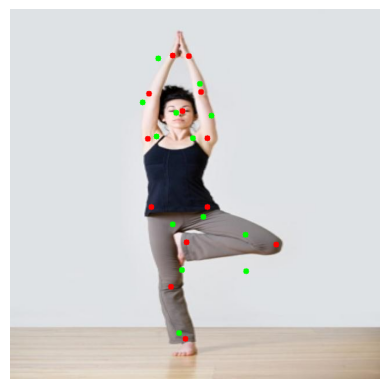

In [5]:
import matplotlib.pyplot as plt

# Draw ground truth keypoints on the image
for x, y in gt_kpts:
    cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), -1)  # Blue circles for ground truth keypoints

for x,y in selected_keypoints:
    cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image)
plt.axis('off')
plt.show()